In [1]:
#Import de librerias basicas tablas y matrices
import numpy as np 
import pandas as pd 

#Gradient Boosting
import lightgbm as lgb

#Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold #Split y cross Validation
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score #Metricas
from sklearn.utils import shuffle 

#Visualizacióon
from plotly import express as px

#Plot de matriz de confusion normalizada en actuals
from utils import plot_confusion_matrix

import os

#Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

#Guardado de objetos en archivos joblib
from joblib import load, dump


/Users/noeliarey/Library/Caches/pypoetry/virtualenvs/codigo-5eSLDjlw-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths para acceso archivos
#Este notebook asume la siguiente estructura de carpetas a partir de la ubicacion de base_dir 
#(dos niveles arriba de la cƒarpeta donde se ejecuta el notebook). 
# /ƒ/ƒ
# /UA_MDM_Labo2/inputƒ
# /UA_MDM_Labo2/input/petfinder-adoption-prediction/            <- Aca deben ir todos los archivos de datos de la competencia 
# /UA_MDM_Labo2/tutoriales/                       <- Aca deben poner los notebooks y scripts que les compartimos
# /UA_MDM_Labo2/work/                             <- Resultados de notebooks iran dentro de esta carpeta en subcarpetas
# /UA_MDM_Labo2/work/models/                     <- Modelos entrenados en archivos joblibs
# /UA_MDM_Labo2/work/optuna_temp_artifacts/      <- Archivos que queremos dejar como artefacto de un trial de optuna (optuna los copiara a la carpeta de abajo)
# /UA_MDM_Labo2/work/optuna_artifacts/           <- Archivos con artefactos que sibimos a optuna

#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_Labo2
BASE_DIR = '../'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")


SEED = 42 #Semilla de procesos aleatorios (para poder replicar exactamente al volver a correr un modelo)
TEST_SIZE = 0.2 #Facción para train/test= split

In [3]:
# Datos Tabulares
dataset = pd.read_csv(PATH_TO_TRAIN)

In [4]:
#Columnas del dataset
dataset.columns


Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [5]:
#Armo listas con features de texto y numericas
char_feats = [f for f in dataset.columns if dataset[f].dtype=='O']
numeric_feats = [f for f in dataset.columns if dataset[f].dtype!='O']

In [6]:
# Lista de nombres genéricos que NO consideramos verdaderos nombres
nombres_invalidos = ['Unnamed', 'No name', 'No Name Yet', 'Urgent', 'Lost Dog']

# Rellenamos nulos
dataset['Name'] = dataset['Name'].fillna('Unnamed')

# Identificamos si contienen dígitos
contiene_numeros = dataset['Name'].str.contains(r'\d', regex=True)

# Extension del nombre
extension = (dataset['Name'].str.len() <= 3) | (dataset['Name'].str.len() > 15)

# Creamos la columna Has_name: 1 si no es inválido y no contiene números
dataset['Has_name'] = (~dataset['Name'].isin(nombres_invalidos) & ~contiene_numeros & ~extension).astype(int)


In [7]:
# Ejemplos de animales que NO tienen nombre real (Has_name = 0)
print("🐾 Ejemplos sin nombre real:")
print(dataset[dataset['Has_name'] == 0][['Name']].sample(10, random_state=1))

# Ejemplos de animales que SÍ tienen nombre real (Has_name = 1)
print("\n🐶 Ejemplos con nombre real:")
print(dataset[dataset['Has_name'] == 1][['Name']].sample(10, random_state=2))

🐾 Ejemplos sin nombre real:
                       Name
13662               Unnamed
4967                    C3C
4122                Unnamed
14568  SNOWEE And 5 Kittens
839        2 Female Puppies
3026              Doggie R2
598    Tabby Girls And Boys
1100                Unnamed
9334                    C4C
11946    Chihuahua Mix Pups

🐶 Ejemplos con nombre real:
                Name
1912     Kity & Mini
5470       Dr. James
7905            Lady
2169          Wolfie
2421           Hazel
9920   Munchkin Miko
3102          Jelita
5715           Comot
8967           Mochi
12558         Velvet


In [38]:
dataset.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,gratis,Is_female_intact,Is_male_intact,Rescuer_repetido,Dog_male,Cat_male,Video,Fotos,Descripcion_linda,Color_combo
0,2,Nibble,3,299,0,1,1,7,0,1,...,0,False,True,1,0,1,0,1,1,0_1_7
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,False,False,0,0,1,0,1,0,0_1_2
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,False,True,1,1,0,0,2,1,0_2_7
3,1,Miko,4,307,0,2,1,2,0,2,...,0,True,False,1,0,0,0,2,0,0_1_2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,False,True,1,1,0,0,1,1,0_0_1


In [8]:
# Largo de la descripcion
dataset['Description_length'] = dataset['Description'].str.len()

In [9]:
# Score de salud 
dataset['Cuidado_Medico'] = (
    (dataset['Vaccinated'] == 1).astype(int) +
    (dataset['Dewormed'] == 1).astype(int) +
    (dataset['Sterilized'] == 1).astype(int)
)

In [10]:
# Edad
def clasificar_edad(age):
    if age <= 6:
        return 1  # Cachorro
    elif age > 72:
        return 4 # Adulto Mayor
    elif age > 24:
        return 3  # Adulto
    else:
        return 2  # Normal

dataset['Age_group'] = dataset['Age'].apply(clasificar_edad)


In [11]:
# Raza
dataset['Raza_pura'] = np.where(
    (dataset['Breed1'] != 307) & (dataset['Breed2'] == 0), 1, 0
)

In [12]:
# Cantidad de mascotas a adoptar 

def clasificar_cantidad(q):
    if q == 1:
        return 0
    elif q <= 3:
        return 1
    elif q <= 6:  # Cambiado a <= 6 para incluir hasta 6
        return 2
    else:
        return 3

dataset['Cant_Adopcion'] = dataset['Quantity'].apply(clasificar_cantidad)

In [13]:
# Color 

dataset['color_count'] = (
    (dataset['Color1'] != 0).astype(int) +
    (dataset['Color2'] != 0).astype(int) +
    (dataset['Color3'] != 0).astype(int)
)

In [14]:
# Adopcion gratuita

dataset['gratis'] = (dataset['Fee'] == 0).astype(int)

In [15]:
# Genero y castracion

dataset['Is_female_intact'] = (dataset['Gender'] == 2) & (dataset['Sterilized'] == 2)
dataset['Is_male_intact'] = (dataset['Gender'] == 1) & (dataset['Sterilized'] == 2)


In [16]:
# RescuerID repetidos

dataset['Rescuer_repetido'] = dataset.duplicated('RescuerID', keep=False).astype(int)

### Agregadas en experimento 4

In [17]:
# Gato y Perro segun genero

dataset['Dog_male'] = ((dataset['Type'] == 1) & (dataset['Gender'] == 1)).astype(int)
dataset['Cat_male'] = ((dataset['Type'] == 2) & (dataset['Gender'] == 1)).astype(int)

In [18]:
# Hay videos
dataset['Video'] = (dataset['VideoAmt'] > 1).astype(int)

In [20]:
# Cantidad de fotos

def clasificar_fotos(x):
    if x == 0:
        return 0
    elif x <= 5:
        return 1
    else:
        return 2

dataset['Fotos'] = dataset['PhotoAmt'].apply(clasificar_fotos)

In [21]:
import re

# Lista de palabras clave (en minúsculas)
palabras_lindas = [
    'love', 'loving', 'sweet', 'friendly', 'cute', 'adorable',
    'affectionate', 'gentle', 'cuddly', 'playful', 'happy', 'kind',
    'compassionate', 'endearing', 'charming', 'delightful', 'joyful', 'precious']

# Expresión regular que detecta si alguna palabra está presente
patron = r'\b(' + '|'.join(palabras_lindas) + r')\b'

# Crear variable binaria
dataset['Descripcion_linda'] = dataset['Description'].str.lower().str.contains(patron, flags=re.IGNORECASE, na=False).astype(int)

/var/folders/tx/rstdr46s2ng5_qbbc6p67xv40000gn/T/ipykernel_48489/33724552.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dataset['Descripcion_linda'] = dataset['Description'].str.lower().str.contains(patron, flags=re.IGNORECASE, na=False).astype(int)


In [39]:
# Combinacion de colores
def sorted_color_combo(row):
    colores = sorted([row['Color1'], row['Color2'], row['Color3']])
    return int(''.join(map(str, colores)))

dataset['Color_combo'] = dataset.apply(sorted_color_combo, axis=1)

In [40]:
# Features menos estas variables 

var_to_remove = ['Description', 'RescuerID', 'PetID', 'Name', 'AdoptionSpeed']

features = [f for f in dataset.columns if f not in var_to_remove]

label = 'AdoptionSpeed'


In [41]:
dataset.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Has_name', 'Description_length', 'Cuidado_Medico', 'Age_group',
       'Raza_pura', 'Cant_Adopcion', 'color_count', 'gratis',
       'Is_female_intact', 'Is_male_intact', 'Rescuer_repetido', 'Dog_male',
       'Cat_male', 'Video', 'Fotos', 'Descripcion_linda', 'Color_combo'],
      dtype='object')

In [42]:
#Separo un 20% para test estratificado opr target
train, test = train_test_split(dataset,
                               test_size = TEST_SIZE,
                               random_state = SEED,
                               stratify = dataset.AdoptionSpeed)

In [43]:
#Genero dataframes de train y test con sus respectivos targets
X_train = train[features]
y_train = train[label]

X_test = test[features]
y_test = test[label]

In [44]:
#Entreno un modelo inicial sin modificar hiperparametros. Solamente especifico el numero de clases y el tipo de modelo como clasificacoión
lgb_params = params = {
                        'objective': 'multiclass',
                        'num_class': len(y_train.unique())
                        }


#genero el objeto Dataset que debo pasarle a lightgbm para que entrene
lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)

#entreno el modelo con los parametros por defecto
lgb_model = lgb.train(lgb_params,
                      lgb_train_dataset)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 36
[LightGBM] [Info] Start training from score -3.599148
[LightGBM] [Info] Start training from score -1.579379
[LightGBM] [Info] Start training from score -1.311924
[LightGBM] [Info] Start training from score -1.526206
[LightGBM] [Info] Start training from score -1.273359


In [45]:
lgb_model.predict(X_test).argmax(axis=1)

array([2, 1, 2, ..., 1, 4, 4], shape=(2999,))

In [46]:
#Obtengo las predicciones sobre el set de test. El modelo me da una lista de probabilidades para cada clase y tomo la clase con mayor probabilidad con la funcion argmax
y_pred = lgb_model.predict(X_test).argmax(axis=1)

#Calculo el Kappa
cohen_kappa_score(y_test,y_pred, weights = 'quadratic')

0.3222655806978707

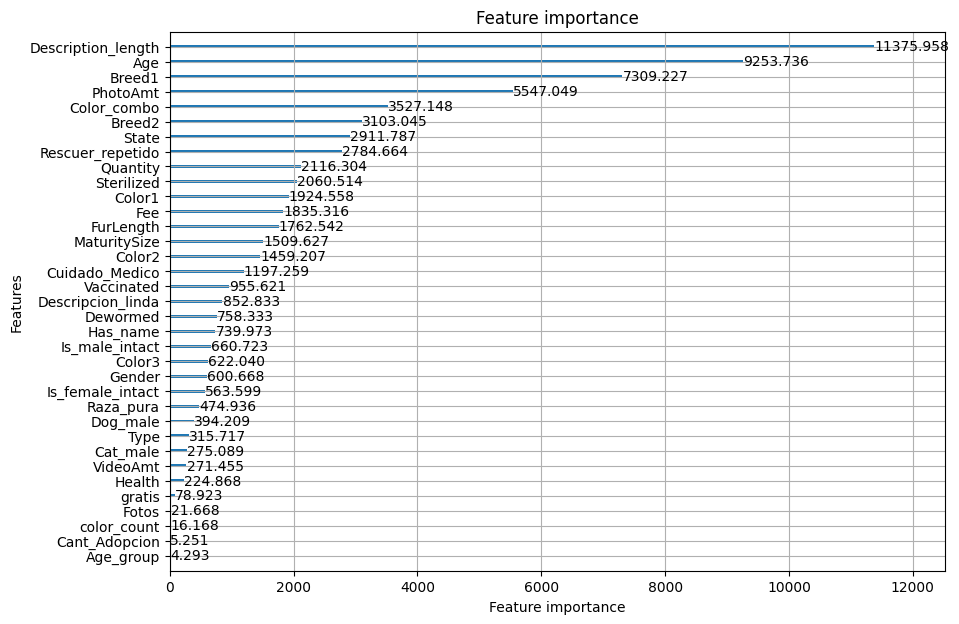

In [57]:
import lightgbm as lgb
import matplotlib.pyplot as plt

    # Assuming 'model' is your trained LightGBM model
ax = lgb.plot_importance(lgb_model, importance_type="gain", figsize=(10, 7))
ax.figure.savefig("feature_importance.png")

In [47]:
#Muestro la matriz de confusión
display(plot_confusion_matrix(y_test,y_pred))

In [30]:
#Pruebo un modelo alternativo donde en vez de usar la version multiclass real de lightGBM utilizo One vs All

lgb_params = params = {
                        'objective': 'multiclassova',
                        'num_class': len(y_train.unique())
                        }


lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


lgb_model = lgb.train(lgb_params,
                      lgb_train_dataset)

[LightGBM] [Info] Number of positive: 328, number of negative: 11666
[LightGBM] [Info] Number of positive: 2472, number of negative: 9522
[LightGBM] [Info] Number of positive: 3230, number of negative: 8764
[LightGBM] [Info] Number of positive: 2607, number of negative: 9387
[LightGBM] [Info] Number of positive: 3357, number of negative: 8637
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027347 -> initscore=-3.571420
[LightGBM] [Info] Start training from score -3.571420
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206103 -> initscore=-1.348577
[LightGBM] [Info] Start training from score -1.348577
[LightGBM] [Info] [binary:BoostFrom

In [31]:
#MAtriz de confusion y Kappa dfe OVA
y_pred = lgb_model.predict(X_test).argmax(axis=1)

display(plot_confusion_matrix(y_test,y_pred))

{'kappa':cohen_kappa_score(y_test,
                y_pred,
                weights = 'quadratic'),
 'accuracy':accuracy_score(y_test,y_pred),
 'balanced_accuracy':balanced_accuracy_score(y_test,y_pred)}




{'kappa': 0.3343069622440521,
 'accuracy': 0.40913637879293097,
 'balanced_accuracy': 0.33837248464385344}

## Optimizacion de hyperparametros modelo train/test
 

In [ ]:

#Funcion que vamos a optimizar. Optuna requiere que usemos el objeto trial para generar los parametros a optimizar
def lgb_objective(trial):
    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        #Hiperparametros a optimizar utilizando suggest_float o suggest_int segun el tipo de dato
                        #Se indica el nombre del parametro, valor minimo, valor maximo 
                        #en elgunos casos el parametro log=True para parametros que requieren buscar en esa escala
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        } 

    #Genero objeto dataset de entrenamiento
    lgb_train_dataset = lgb.Dataset(data=X_train,
                                    label=y_train)

    #ajuste de modelo
    lgb_model = lgb.train(lgb_params,
                        lgb_train_dataset)
    
    #Devuelvo el score en test
    return(cohen_kappa_score(y_test,lgb_model.predict(X_test).argmax(axis=1),
                             weights = 'quadratic'))

In [60]:
#Defino el estudio a optimizar
study = optuna.create_study(direction='maximize', #buscamos maximizar la metrica
                            storage="sqlite:///../work/db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - LGB Multiclass G2", #nombre del experimento
                            load_if_exists=True) #continuar si ya existe

#Corremos 100 trials para buscar mejores parametros
study.optimize(lgb_objective, n_trials=100)

[I 2025-07-25 17:16:08,254] Using an existing study with name '04 - LGB Multiclass G2' instead of creating a new one.
[I 2025-07-25 17:16:15,203] Trial 100 finished with value: 0.29618241096183695 and parameters: {'lambda_l1': 0.06627046428575126, 'lambda_l2': 6.07051584427789e-07, 'num_leaves': 286, 'feature_fraction': 0.4680316817718708, 'bagging_fraction': 0.7040499633206639, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 97 with value: 0.3433236690052913.
[I 2025-07-25 17:16:34,916] Trial 101 finished with value: 0.2872296297598148 and parameters: {'lambda_l1': 0.004995392708077501, 'lambda_l2': 5.990182189842035e-06, 'num_leaves': 387, 'feature_fraction': 0.9439728457307385, 'bagging_fraction': 0.6827217418062578, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 97 with value: 0.3433236690052913.
[I 2025-07-25 17:16:41,589] Trial 102 finished with value: 0.29606711482127757 and parameters: {'lambda_l1': 0.0072289865528711245, 'lambda_l2': 7.615869730750793e-0

In [64]:
#Obtenemos mejor resultado
study.best_params

{'lambda_l1': 0.012516996228054654,
 'lambda_l2': 1.5886349475239832e-06,
 'num_leaves': 36,
 'feature_fraction': 0.9663689722295274,
 'bagging_fraction': 0.6861211012982429,
 'bagging_freq': 7,
 'min_child_samples': 17}

In [65]:
#Vamos a replicar el resultado de la optimizacion reentrenando el modelo con el mejor conjunto de hiperparametros
#Generamos parametros incluyendo los fijos y la mejor solución que encontro optuna
lgb_params =  {      
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique())} | study.best_params

lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


#Entreno
lgb_model = lgb.train(lgb_params,
                    lgb_train_dataset)

#Muestro matriz de confusion y kappa
display(plot_confusion_matrix(y_test,lgb_model.predict(X_test).argmax(axis=1)))

cohen_kappa_score(y_test,lgb_model.predict(X_test).argmax(axis=1),
                             weights = 'quadratic')


0.3433236690052913

## Modelo con cross validation y conjunto de test


In [58]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(),dy_pred.argmax(axis=1),weights = 'quadratic')
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_lgb_objective(trial):

    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        #Hiperparametros a optimizar utilizando suggest_float o suggest_int segun el tipo de dato
                        #Se indica el nombre del parametro, valor minimo, valor maximo 
                        #en elgunos casos el parametro log=True para parametros que requieren buscar en esa escala
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.1, log=True),
                        'n_estimators':5000
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        #Dataset in fold (donde entreno) 
        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                        label=y_train.iloc[if_index],
                                        free_raw_data=False)
        
        #Dataset Out of fold (donde mido la performance del CV)
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                        label=y_train.iloc[oof_index],
                                        free_raw_data=False)

        #Entreno el modelo
        lgb_model = lgb.train(lgb_params,
                                lgb_if_dataset,
                                valid_sets=lgb_oof_dataset,
                                callbacks=[lgb.early_stopping(10, verbose=False)],
                                feval = lgb_custom_metric_kappa
                                )
        
        #Acumulo los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        #Se predice el 20% de los datos que separe para tes y no uso para entrenar en ningun fold
        scores_ensemble = scores_ensemble + lgb_model.predict(X_test)
        
        #Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds = score_folds + cohen_kappa_score(y_train.iloc[oof_index], 
                                                            lgb_model.predict(X_train.iloc[oof_index]).argmax(axis=1),weights = 'quadratic')/n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    fi_filename = os.path.join(PATH_TO_TEMP_FILES,f'fi_{trial.study.study_name}_{trial.number}.png')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    # feature importance
    ax = lgb.plot_importance(lgb_model, importance_type="gain", figsize=(10, 7))
    ax.figure.savefig(fi_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)
    upload_artifact(trial, fi_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = cohen_kappa_score(y_test,scores_ensemble.argmax(axis=1),weights = 'quadratic')
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///../work/db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - LGB Multiclass CV G2_04",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_lgb_objective, n_trials=100)

[I 2025-07-26 12:09:17,510] Using an existing study with name '04 - LGB Multiclass CV G2_04' instead of creating a new one.
/var/folders/tx/rstdr46s2ng5_qbbc6p67xv40000gn/T/ipykernel_48489/3809418348.py:88: FutureWarning:

upload_artifact() got {'file_path', 'study_or_trial', 'artifact_store'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['study_or_trial', 'file_path', 'artifact_store'] in upload_artifact() have been deprecated since v4.0.0. They will be replaced with the corresponding keyword arguments in v6.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v4.0.0 for details.

/var/folders/tx/rstdr46s2ng5_qbbc6p67xv40000gn/T/ipykernel_48489/3809418348.py:100: FutureWarning:

upload_artifact() got {'file_path', 'study_or_trial', 'artifact_store'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['study_or_trial', 'file_path